In [1]:
import pandas as pd
import numpy as np
import sklearn

import pandas_datareader.data as web
import datetime as dt
import quandl
import recession_modeling as rm #custom module and function

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import metrics
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, precision_recall_curve,f1_score, fbeta_score

import scikitplot as skplt
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

## Gathering Initial Data for MVP

In [2]:
#Defining start and end date for pandas data reader
start = dt.datetime(1950, 1, 1)
end = dt.datetime(2019, 8, 31)

In [3]:
#Getting FRED datastreams using DataReader
fred = web.DataReader(['GS10', 'TB3MS', 'USREC', 'CSCICP03USM665S'], 'fred', start, end)
fred.reset_index(drop = False, inplace = True)
fred.columns = ['Date','10_Year','3_Month','Recession','Consumer Sentiment']

In [4]:
#Making new feature for 10 Year, 3 Month yield spread
fred['10Y-3M'] = fred['10_Year'] - fred['3_Month']

In [5]:
#Need each row to have full set of data
fred.dropna(inplace = True)
fred.reset_index(drop = True, inplace = True)

In [6]:
#Formating dates to Year/month to merge dataframes easily
fred['Date'] = fred['Date'].dt.strftime('%Y-%m')

In [7]:
#Getting copper and gold datastreams using DataReader
#End goal is to find copper/gold ratio
metals = quandl.get(['CHRIS/CME_HG2','LBMA/GOLD'], collapse = 'monthly')
metals.reset_index(drop = False, inplace = True)

In [8]:
metals = metals[['Date','CHRIS/CME_HG2 - Settle','LBMA/GOLD - USD (AM)']]
metals.columns = ['Date', 'Copper', 'Gold']

In [9]:
metals.dropna(inplace = True)
metals.reset_index(drop = True, inplace = True)
metals['Date'] = metals['Date'].dt.strftime('%Y-%m') #No need for days, economic releases assumed end of month

In [10]:
metals['Copper/Gold'] = np.log(metals['Copper'] / metals['Gold'])
metals = metals[['Date','Copper/Gold']].copy()

In [11]:
metals.head(3)

,Date,Copper/Gold
0,1968-07,-4.488816
1,1968-08,-4.493680
2,1968-09,-4.420542


In [12]:
#Merging both dataframes to complete feature set
df = (pd.merge(fred, metals, on='Date'))
df['Date'] = pd.to_datetime(df['Date'])

In [13]:
df.head(5)

,Date,10_Year,3_Month,Recession,Consumer Sentiment,10Y-3M,Copper/Gold
0,1968-07-01,5.50,5.31,0,100.612032,0.19,-4.488816
1,1968-08-01,5.42,5.09,0,100.596721,0.33,-4.493680
2,1968-09-01,5.46,5.19,0,100.603771,0.27,-4.420542
3,1968-10-01,5.58,5.35,0,100.677831,0.23,-4.460540
4,1968-11-01,5.70,5.45,0,100.851819,0.25,-4.426410


## EDA

Have to shift yield spreads forward a certain amount of time to see if spreads have any predictive power
into future

Let's start with 6 months, 9 months, and 12 months

In [14]:
df['10Y-3M 6M Forward'] = df.loc[:,'10Y-3M'].shift(periods=6)
df['10Y-3M 9M Forward'] = df.loc[:,'10Y-3M'].shift(periods=9)
df['10Y-3M 12M Forward'] = df.loc[:,'10Y-3M'].shift(periods=12)

df['C Sentiment 6M Forward'] = df.loc[:,'Consumer Sentiment'].shift(periods=6)
df['C Sentiment 9M Forward'] = df.loc[:,'Consumer Sentiment'].shift(periods=9)
df['C Sentiment 12M Forward'] = df.loc[:,'Consumer Sentiment'].shift(periods=12)

df['C/G 6M Forward'] = df.loc[:,'Copper/Gold'].shift(periods=6)
df['C/G 9M Forward'] = df.loc[:,'Copper/Gold'].shift(periods=9)
df['C/G 12M Forward'] = df.loc[:,'Copper/Gold'].shift(periods=12)

In [15]:
df.head(3)

,Date,10_Year,3_Month,Recession,Consumer Sentiment,10Y-3M,Copper/Gold,10Y-3M 6M Forward,10Y-3M 9M Forward,10Y-3M 12M Forward,C Sentiment 6M Forward,C Sentiment 9M Forward,C Sentiment 12M Forward,C/G 6M Forward,C/G 9M Forward,C/G 12M Forward
0,1968-07-01,5.50,5.31,0,100.612032,0.19,-4.488816,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1968-08-01,5.42,5.09,0,100.596721,0.33,-4.493680,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1968-09-01,5.46,5.19,0,100.603771,0.27,-4.420542,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
df.to_pickle("Data/df.pkl")

In [17]:
# Only if rerunning notebook, avoid extra API calls
df = pd.read_pickle("Data/df.pkl")
df.dropna(inplace = True)

Quick EDA and time series plots of the spread's predicition ability

First take a look at features w/ no lag vs. recessions

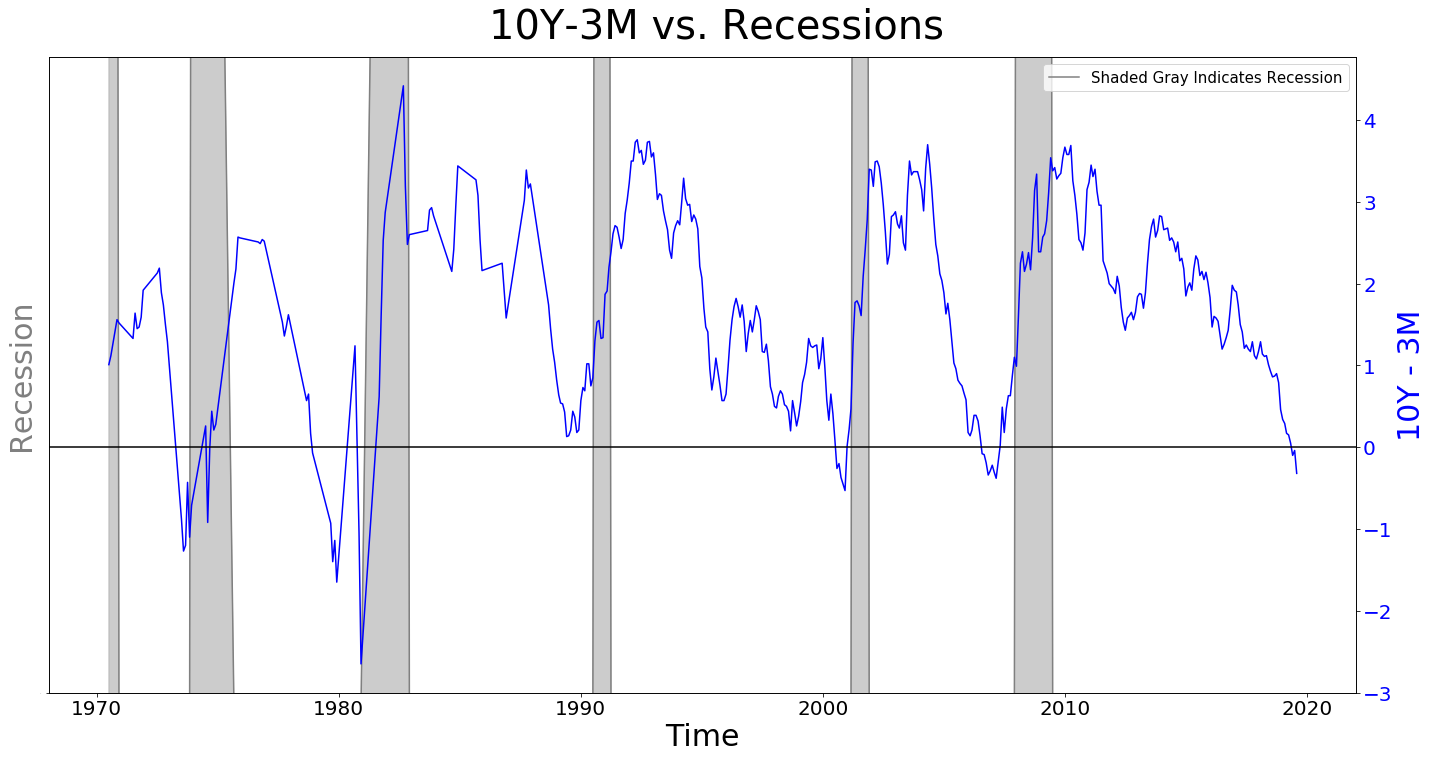

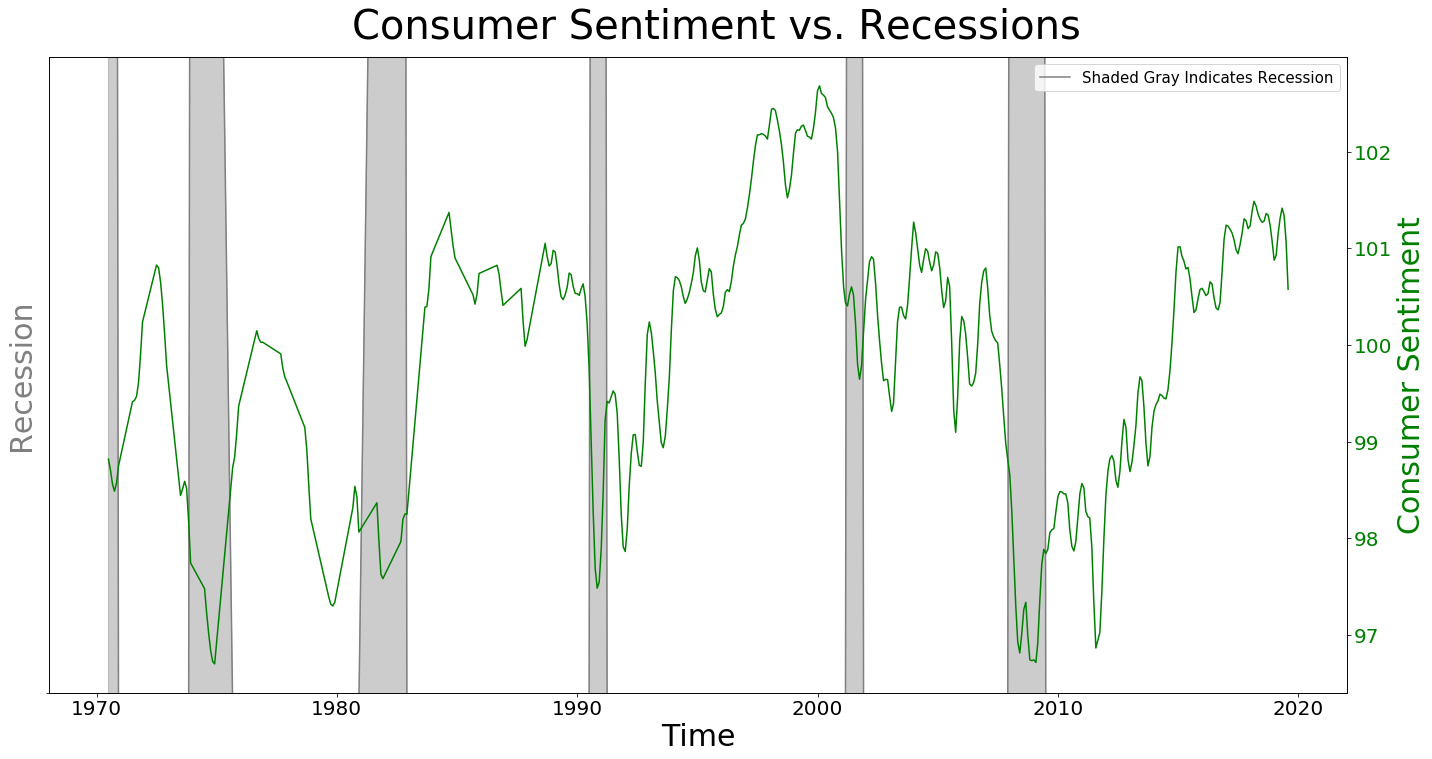

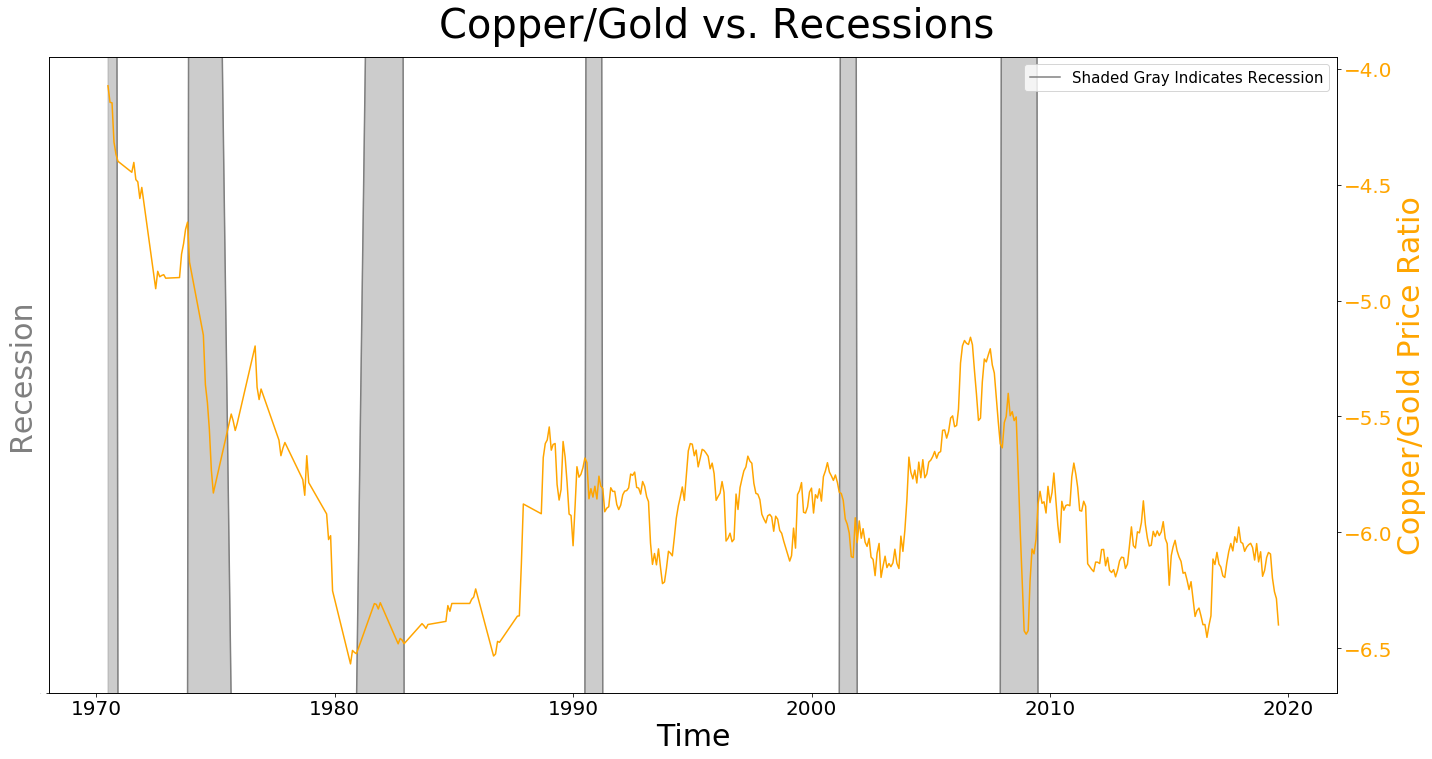

In [19]:
rm.feature_dashboard(df['Date'], df['Recession'], df['10Y-3M'], feature_label = '10Y - 3M', 
                  horizontal_line = True, title = '10Y-3M vs. Recessions')
rm.feature_dashboard(df['Date'], df['Recession'], df['Consumer Sentiment'], feature_label = 'Consumer Sentiment', 
                  feature_color = 'green', horizontal_line = False, title = 'Consumer Sentiment vs. Recessions')
rm.feature_dashboard(df['Date'], df['Recession'], df['Copper/Gold'], feature_label = 'Copper/Gold Price Ratio', 
                  feature_color = 'orange', horizontal_line = False, title = 'Copper/Gold vs. Recessions')

Certainly seems like spreads have led the last few recessions. Now let's look at predictative ability of spreads for 6m

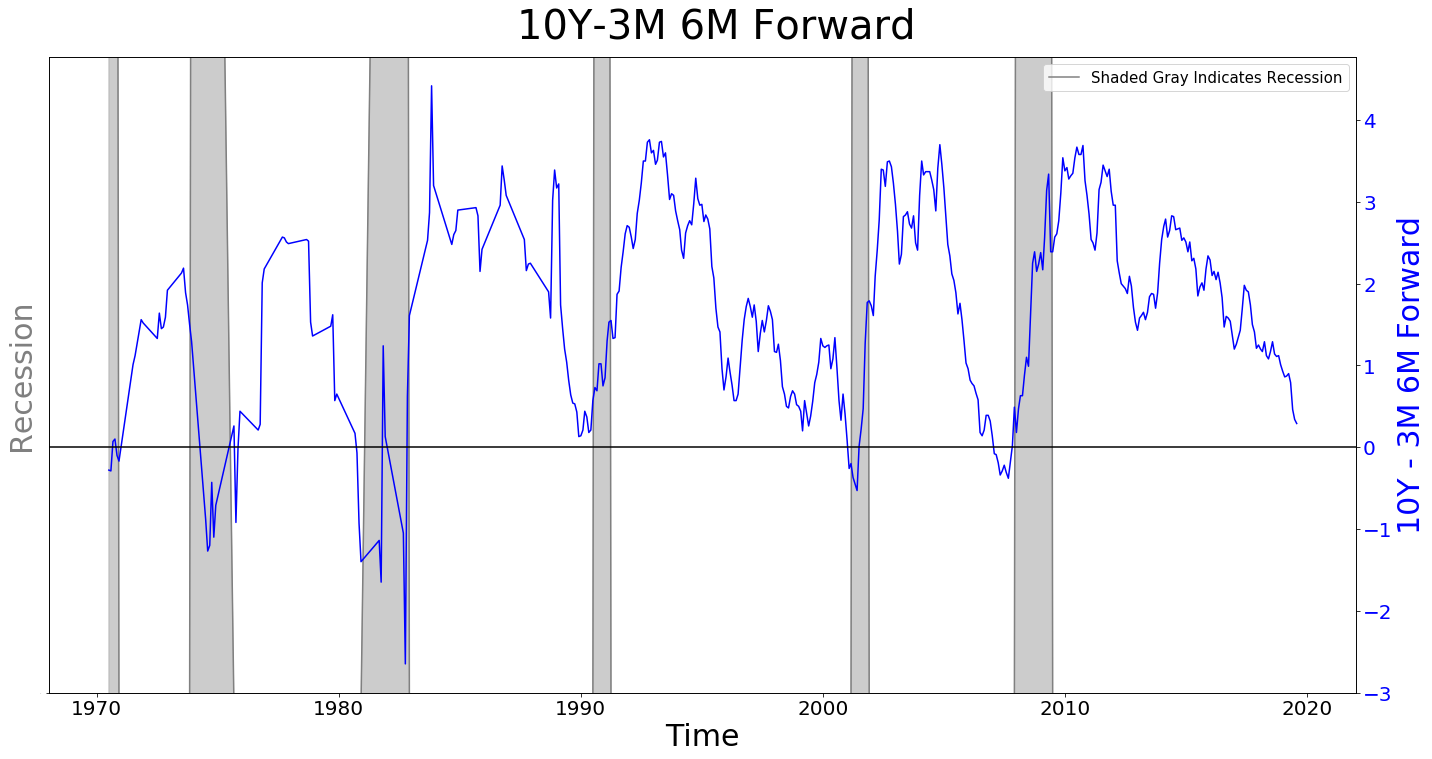

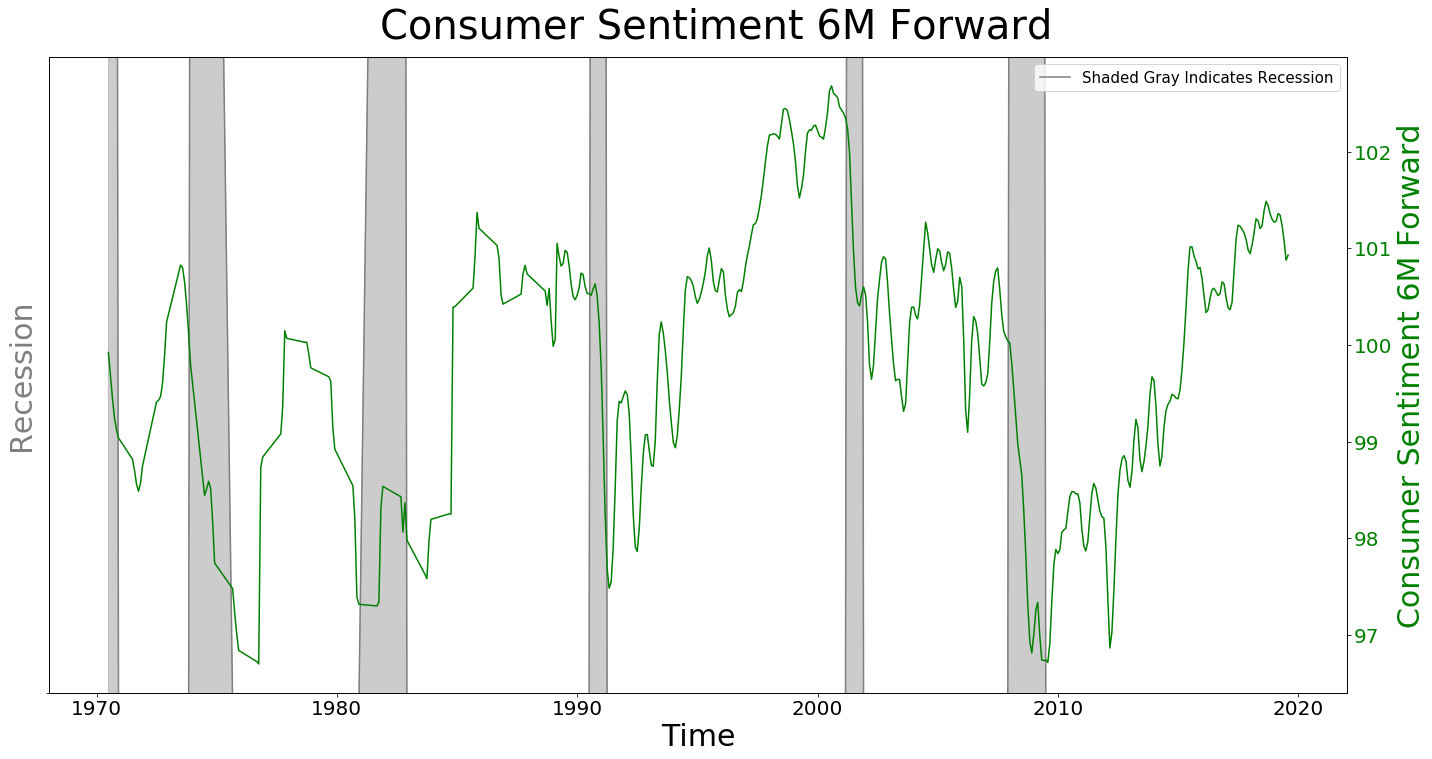

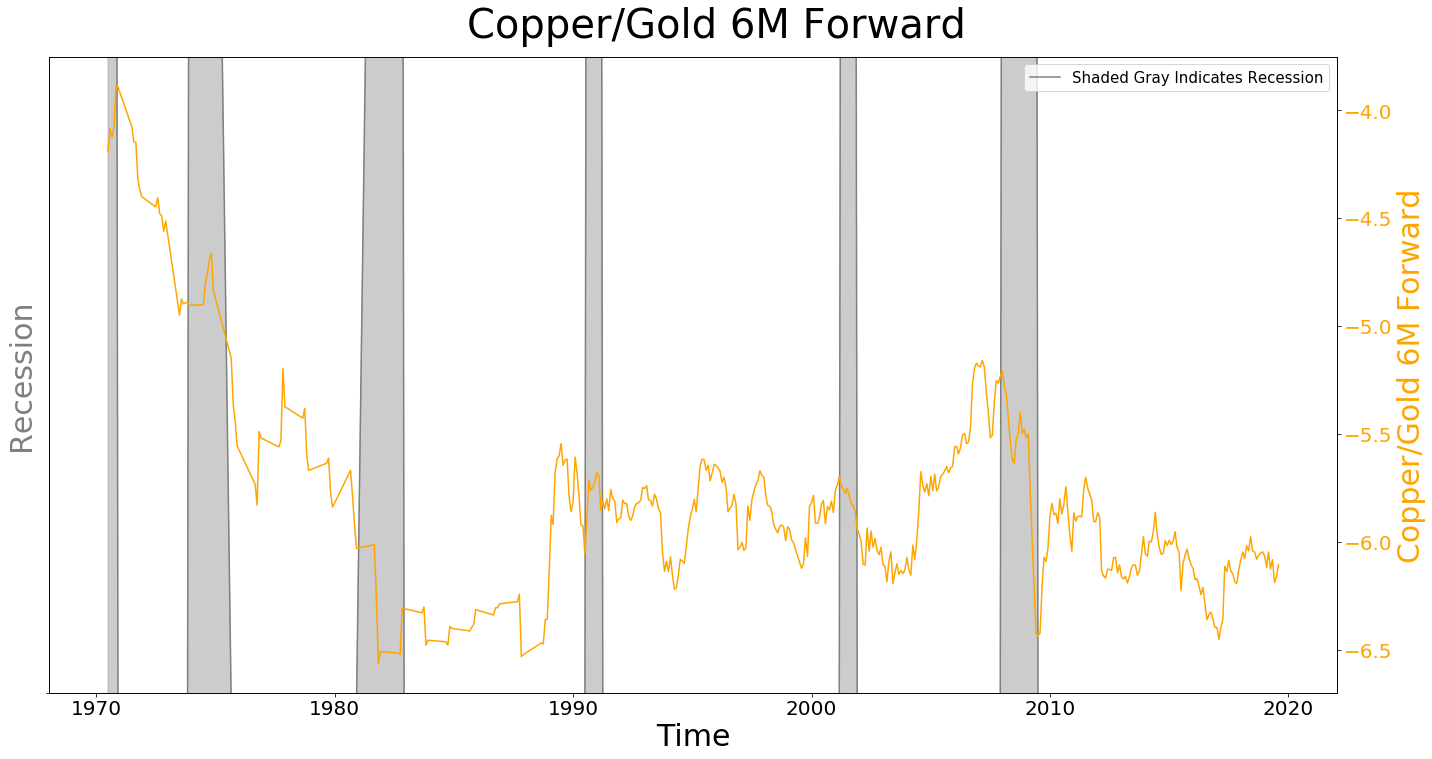

In [20]:
rm.feature_dashboard(df['Date'], df['Recession'], df['10Y-3M 6M Forward'], feature_label = '10Y - 3M 6M Forward', 
                  horizontal_line = True, title = '10Y-3M 6M Forward')
rm.feature_dashboard(df['Date'], df['Recession'], df['C Sentiment 6M Forward'], feature_label = 'Consumer Sentiment 6M Forward', 
                  feature_color = 'green', horizontal_line = False, title = 'Consumer Sentiment 6M Forward')
rm.feature_dashboard(df['Date'], df['Recession'], df['C/G 6M Forward'], feature_label = 'Copper/Gold 6M Forward', 
                  feature_color = 'orange', horizontal_line = False, title = 'Copper/Gold 6M Forward')

Not bad. Let's try 9 months too

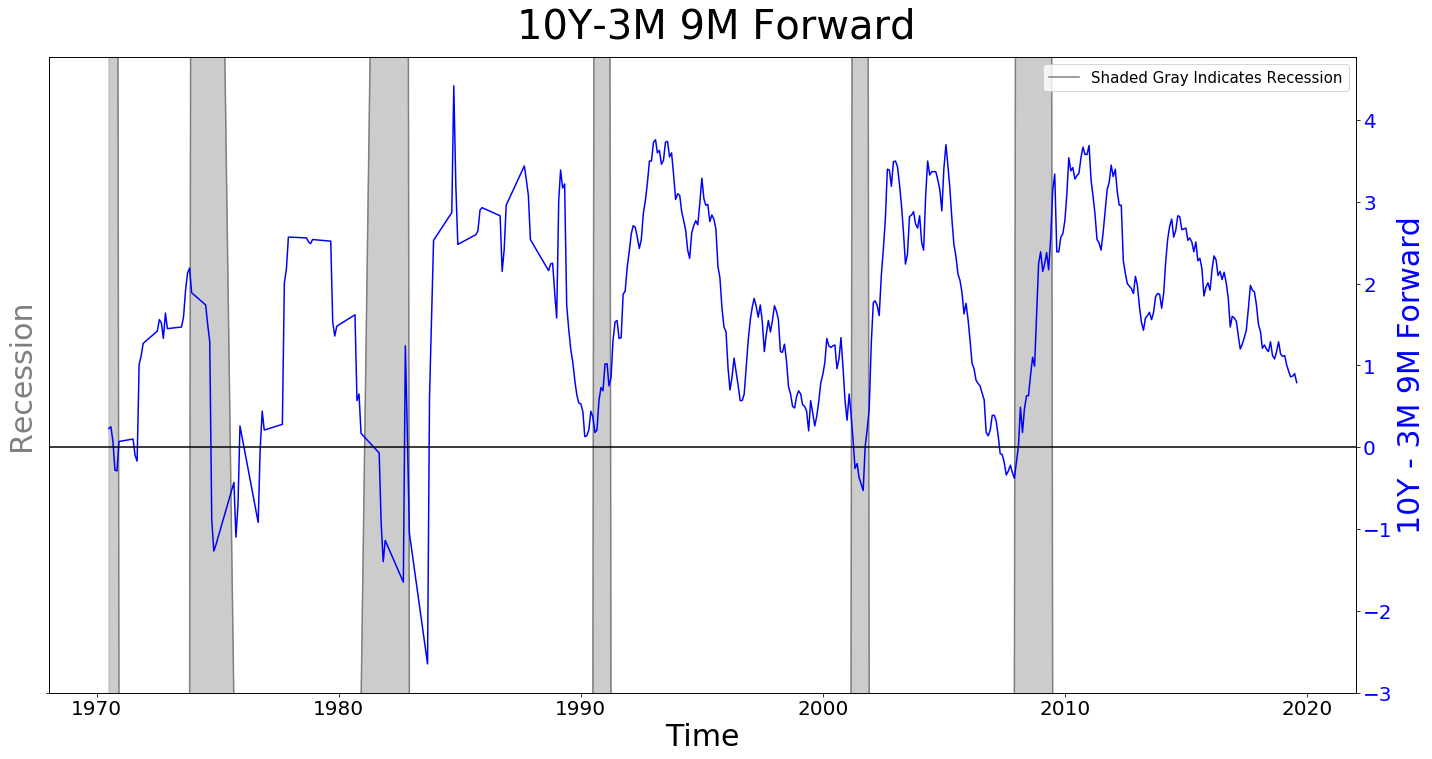

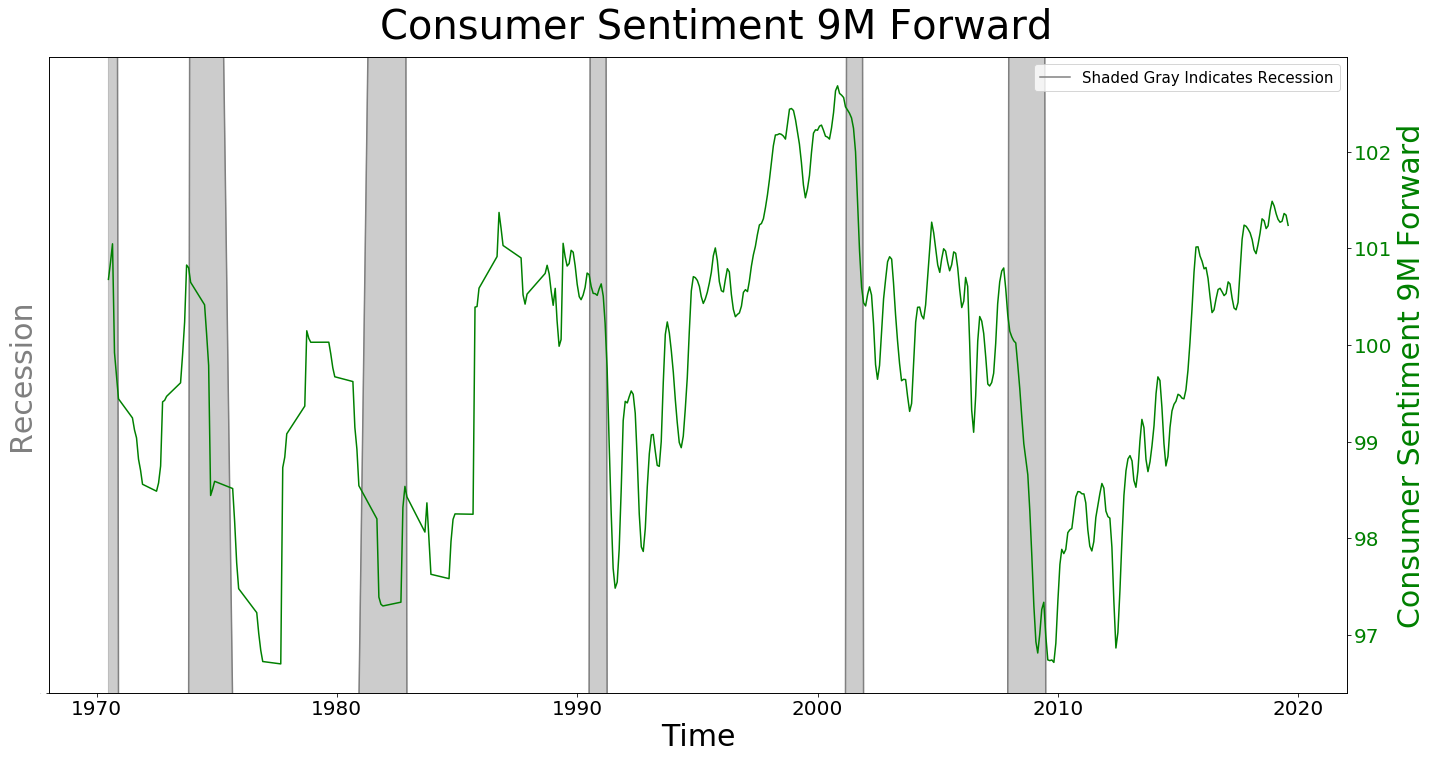

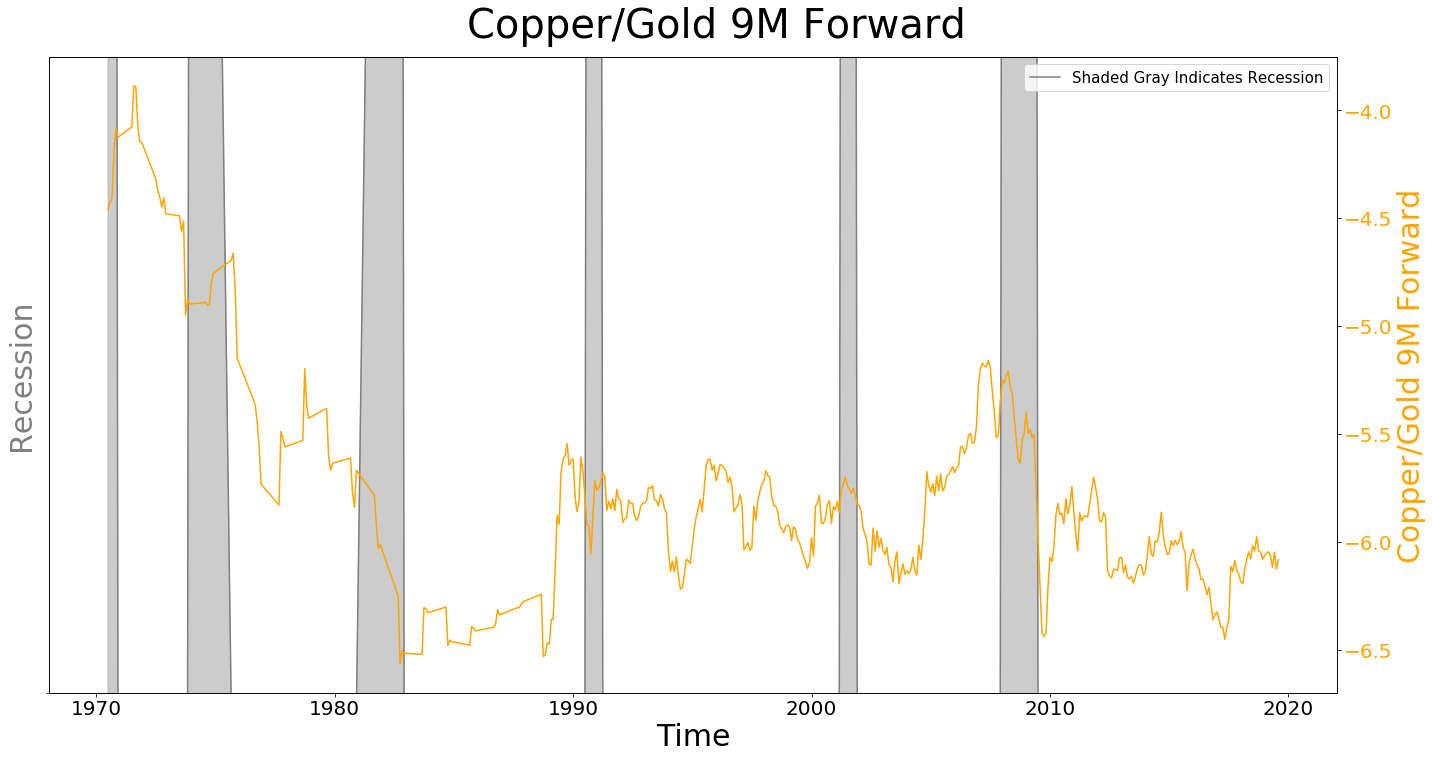

In [21]:
rm.feature_dashboard(df['Date'], df['Recession'], df['10Y-3M 9M Forward'], feature_label = '10Y - 3M 9M Forward', 
                  horizontal_line = True, title = '10Y-3M 9M Forward')
rm.feature_dashboard(df['Date'], df['Recession'], df['C Sentiment 9M Forward'], feature_label = 'Consumer Sentiment 9M Forward', 
                  feature_color = 'green', horizontal_line = False, title = 'Consumer Sentiment 9M Forward')
rm.feature_dashboard(df['Date'], df['Recession'], df['C/G 9M Forward'], feature_label = 'Copper/Gold 9M Forward', 
                  feature_color = 'orange', horizontal_line = False, title = 'Copper/Gold 9M Forward')

And one last time for 12 months

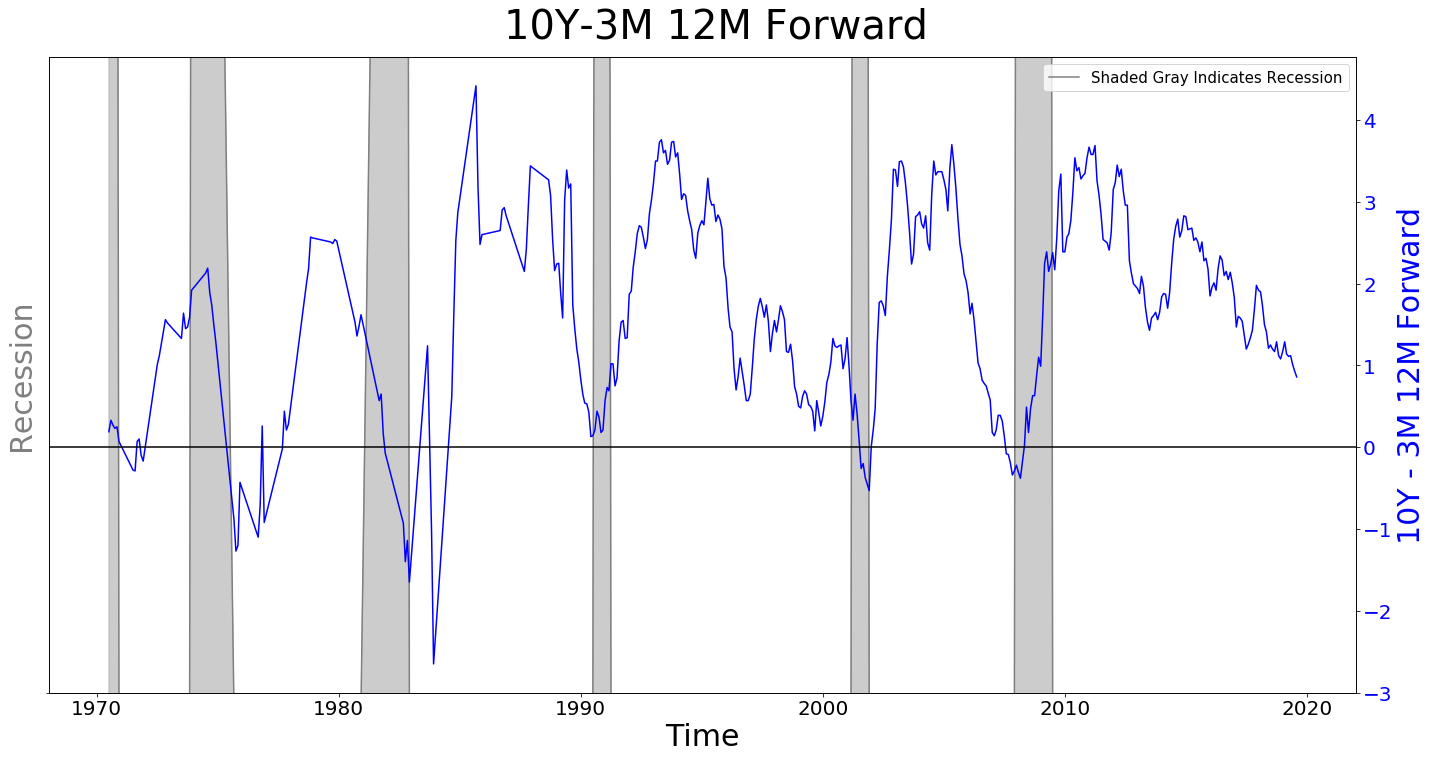

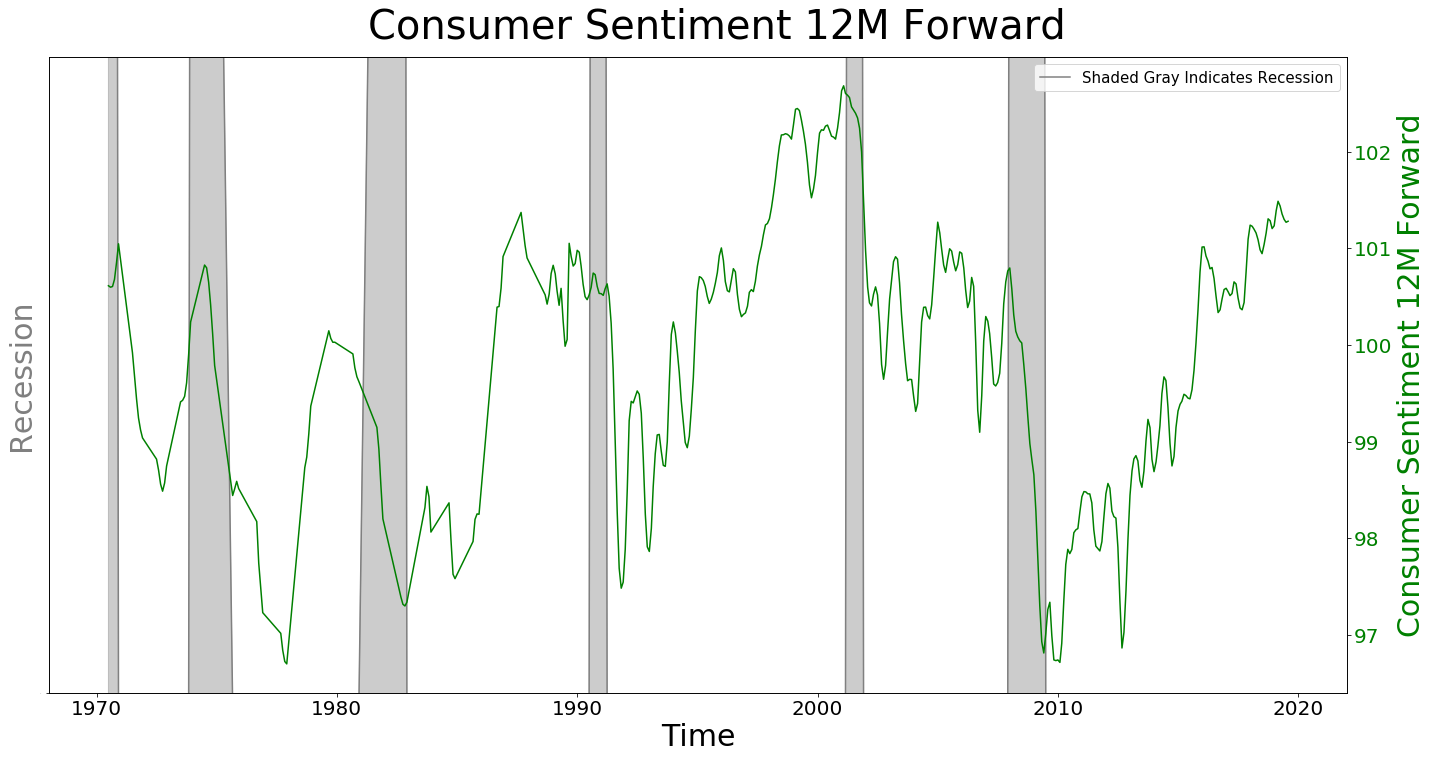

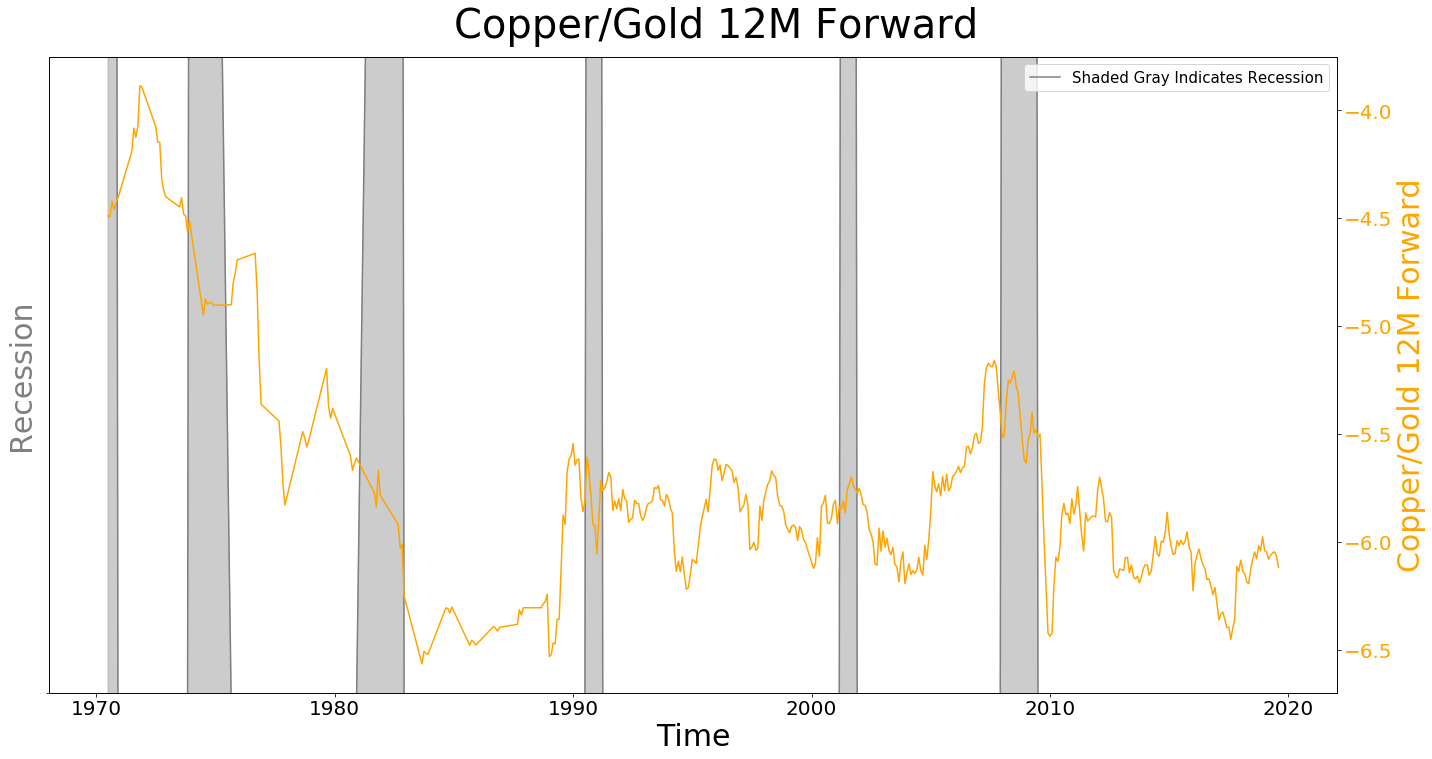

In [22]:
rm.feature_dashboard(df['Date'], df['Recession'], df['10Y-3M 12M Forward'], feature_label = '10Y - 3M 12M Forward', 
                  horizontal_line = True, title = '10Y-3M 12M Forward')
rm.feature_dashboard(df['Date'], df['Recession'], df['C Sentiment 12M Forward'], feature_label = 'Consumer Sentiment 12M Forward', 
                  feature_color = 'green', horizontal_line = False, title = 'Consumer Sentiment 12M Forward')
rm.feature_dashboard(df['Date'], df['Recession'], df['C/G 12M Forward'], feature_label = 'Copper/Gold 12M Forward', 
                  feature_color = 'orange', horizontal_line = False, title = 'Copper/Gold 12M Forward')

Overall, based on simple EDA, it looks like the 6 month forward spread is best indicator of recession

## Logistic Regression for Recession Probabilities

Let's start with a baseline logistic regression model based on the New York Federal Reserve Recession Probability Model. For the baseline model, the percent chance of a recession is simply a function of the 10Y-3M Spread

In [23]:
df_base = df[['Date','Recession','10Y-3M 6M Forward']].copy()
df_base.dropna(inplace = True)

In [24]:
#2/3 train, 1/3 test split
cutoff = round(len(df_base) * 0.666)
cutoff

302

In [25]:
cross_validation = df_base[:cutoff]
cross_validation = cross_validation.reset_index(drop = True)
test = df_base[cutoff:]
test = test.reset_index(drop = True)

In [26]:
test.head()

,Date,Recession,10Y-3M 6M Forward
0,2007-01-01,0,0.14
1,2007-02-01,0,-0.08
2,2007-03-01,0,-0.09
3,2007-04-01,0,-0.19
4,2007-05-01,0,-0.34


In [27]:
y_train = cross_validation.Recession
y_test = test.Recession
X_train = cross_validation[['10Y-3M 6M Forward']]
X_test = test[['10Y-3M 6M Forward']]

In [28]:
scaler = preprocessing.StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Let's evaluate the model's ability to predict a recession in a 6-month window, starting 6 months from now. Judging the model on its ability to predict a recession over a 6-month window is more generalizable.

In [29]:
y_test = y_test.to_numpy()

In [30]:
#rolling_6 custom function from recession_modeling.py
y_test_custom = rm.rolling_6(y_test)
y_train_custom = rm.rolling_6(y_train)

Test set AUC:   0.66%
Default Threshold: 0.5
Test Set Precision: 0.4000


Scores for threshold: 0.2
F1: 0.4400, Precision: 0.4074,   Recall: 0.4783


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


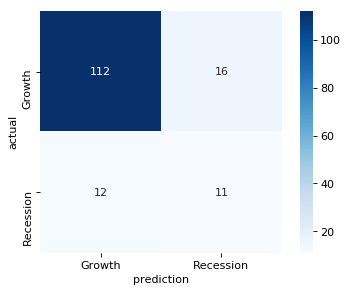

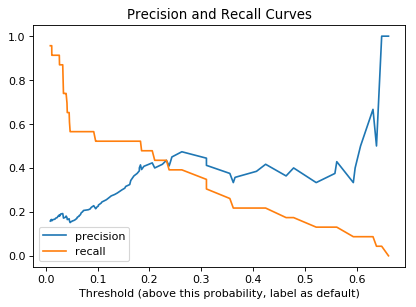

In [31]:
logit = LogisticRegression()

logit_1 = rm.fit_score_viz(logit, X_train, y_train_custom, X_test, y_test_custom)
y_probs_1 = logit_1.predict_proba(X_test)

Now let's add two extra features to see if model improves

In [32]:
df_logit = df[['Date','Recession','10Y-3M 6M Forward','C Sentiment 6M Forward','C/G 6M Forward']].copy()
df_logit.dropna(inplace = True)
#452 months

In [33]:
cutoff = round(len(df_logit) * 0.666)
cutoff

302

In [34]:
cross_validation = df_logit[:cutoff]
cross_validation = cross_validation.reset_index(drop = True)
test = df_logit[cutoff:]
test = test.reset_index(drop = True)

In [35]:
test.head(3)

,Date,Recession,10Y-3M 6M Forward,C Sentiment 6M Forward,C/G 6M Forward
0,2007-01-01,0,0.14,99.610052,-5.184204
1,2007-02-01,0,-0.08,99.706203,-5.189537
2,2007-03-01,0,-0.09,100.014689,-5.158429


In [36]:
y_train = cross_validation.Recession
y_test = test.Recession
X_train = cross_validation[['10Y-3M 6M Forward','C Sentiment 6M Forward','C/G 6M Forward']]
X_test = test[['10Y-3M 6M Forward','C Sentiment 6M Forward','C/G 6M Forward']]

In [37]:
scaler = preprocessing.StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [38]:
y_test = y_test.to_numpy()

In [39]:
y_test_custom = rm.rolling_6(y_test)
y_train_custom = rm.rolling_6(y_train)

Test set AUC:   0.71%
Default Threshold: 0.5
Test Set Precision: 0.3636


Scores for threshold: 0.2
F1: 0.5217, Precision: 0.5217,   Recall: 0.5217


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


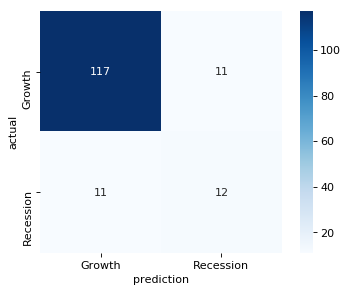

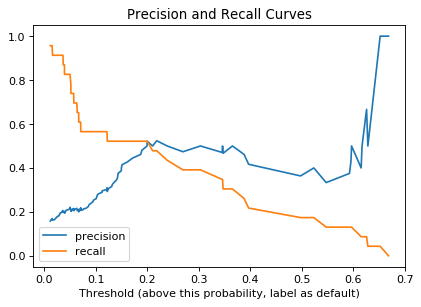

In [40]:
logit_2 = rm.fit_score_viz(logit, X_train, y_train_custom, X_test, y_test_custom)
y_probs_2 = logit_2.predict_proba(X_test)

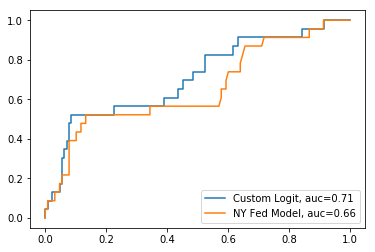

In [41]:
plt.figure(0).clf()

fpr, tpr, thresh = metrics.roc_curve(y_test_custom, y_probs_2[:,1])
auc = metrics.roc_auc_score(y_test_custom, y_probs_2[:,1])
plt.plot(fpr,tpr,label="Custom Logit, auc="+str(round(auc,2)))

fpr, tpr, thresh = metrics.roc_curve(y_test_custom, y_probs_1[:,1])
auc = metrics.roc_auc_score(y_test_custom, y_probs_1[:,1])
plt.plot(fpr,tpr,label="NY Fed Model, auc="+str(round(auc,2)))

plt.legend(loc='lower right');

In [42]:
np.save('Data/y_probs_1', y_probs_1)
np.save('Data/y_probs_2', y_probs_2)
np.save('Data/y_test_custom', y_test_custom)

In [43]:
logit_2.coef_

array([[-1.75921956, -0.12474833,  0.16747948]])

Looks like the extra features, gold/copper and consumer sentiment, helped the new model outperform the 
baseline Fed model!

## Plotting recession probabilities 6 months in future against actual recession

In [44]:
rec_probs = logit_2.predict_proba(X_test)
temp = pd.DataFrame(rec_probs)
temp['Date'] = test['Date']

In [45]:
temp.head(3)

,0,1,Date
0,0.476795,0.523205,2007-01-01
1,0.403485,0.596515,2007-02-01
2,0.404682,0.595318,2007-03-01


In [46]:
test = pd.concat([test, temp], axis=1)

In [47]:
test.dropna(inplace = True)
test.tail(3)

,Date,Recession,10Y-3M 6M Forward,C Sentiment 6M Forward,C/G 6M Forward,0,1,Date
148,2019-06-01,0,0.46,101.072907,-6.188920,0.696990,0.303010,2019-06-01
149,2019-07-01,0,0.34,100.876346,-6.163211,0.654088,0.345912,2019-07-01
150,2019-08-01,0,0.29,100.928805,-6.107702,0.634883,0.365117,2019-08-01


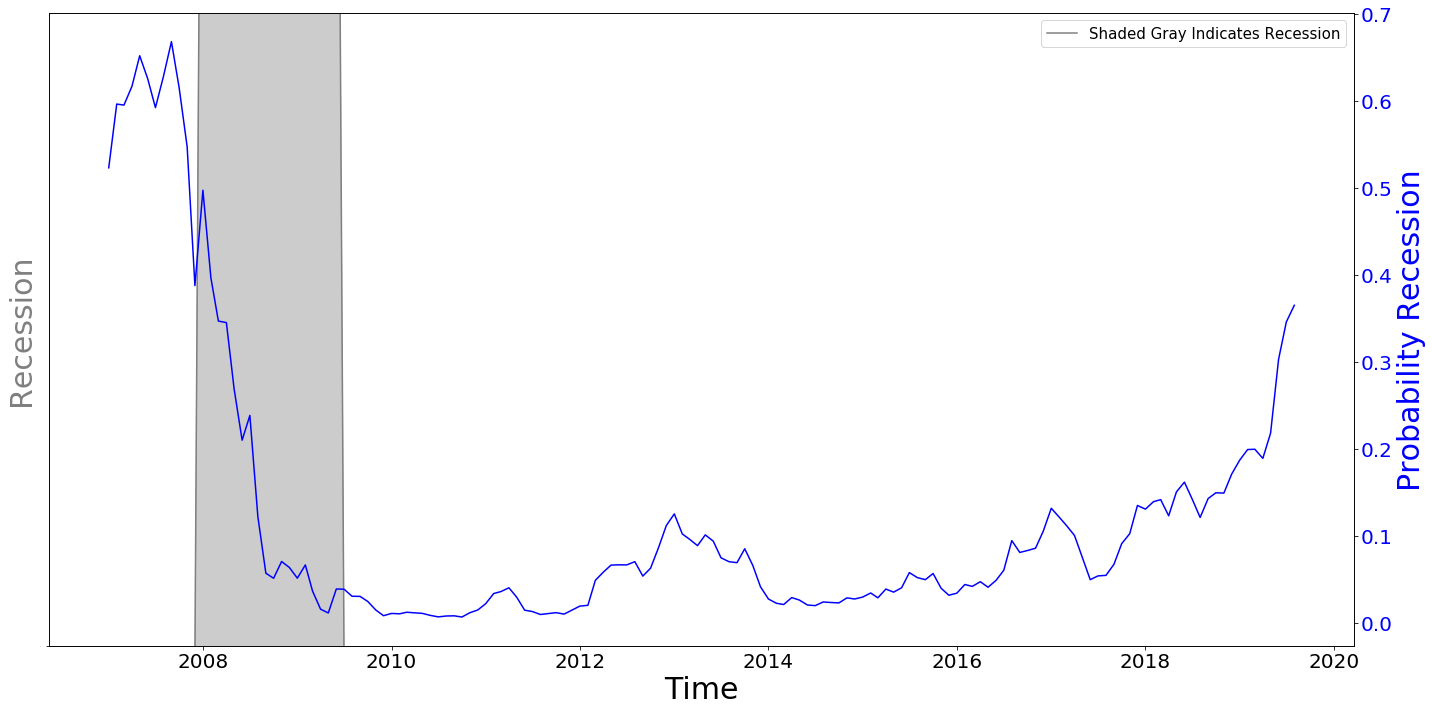

In [48]:
rm.feature_dashboard(test.iloc[:,0], test['Recession'], test[1], feature_label = 'Probability Recession')